In [13]:
from sklearn.preprocessing import StandardScaler
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
import pandas as pd
import numpy as np

In [14]:
train_word_glove_attention = pd.read_csv('final_features/word_attention_glove/train_predictions.csv')
test_word_glove_attention = pd.read_csv('final_features/word_attention_glove/test_predictions.csv')

train_roberta_512 = pd.read_csv('final_features/512_RoBERTa_attention/train_predictions.csv')
test_roberta_512 = pd.read_csv('final_features/512_RoBERTa_attention/test_predictions.csv')

train_longformer_period = pd.read_csv('final_features/period_longformer_att/train_predictions.csv')
test_longformer_period = pd.read_csv('final_features/period_longformer_att/test_predictions.csv')

train_gemini_period = pd.read_csv('final_features/gemini_attention/train_predictions.csv')
test_gemini_period = pd.read_csv('final_features/gemini_attention/test_predictions.csv')
train_gemini_period.drop(['PeriodID'], axis=1, inplace=True)
test_gemini_period.drop(['PeriodID'], axis=1, inplace=True)

train_time_features = pd.read_csv('final_features/time_series/train_time_features.csv')
test_time_features = pd.read_csv('final_features/time_series/test_time_features.csv')

In [15]:
def merge_model_predictions(model_predictions_dict, is_train=True):
    """
    Merge predictions from different models into a single DataFrame.
    
    Args:
        model_predictions_dict: Dictionary with model names as keys and prediction DataFrames as values
        is_train: Boolean indicating if this is training data
    
    Returns:
        Merged DataFrame with predictions from all models
    """
    merge_cols = ['ID']
    if is_train:
        merge_cols.append('EventType')
    
    # Start with the first DataFrame
    first_model_name = list(model_predictions_dict.keys())[0]
    merged_df = model_predictions_dict[first_model_name]
    
    # Merge with remaining DataFrames
    for model_name in list(model_predictions_dict.keys())[1:]:
        merged_df = pd.merge(
            merged_df,
            model_predictions_dict[model_name],
            on=merge_cols,
            how='inner'
        )
    
    return merged_df


train_predictions = {
    'word_glove_attention': train_word_glove_attention,
    'roberta_512': train_roberta_512,
    'longformer_period': train_longformer_period,
    'gemini_period': train_gemini_period
}

train_models = merge_model_predictions(train_predictions, is_train=True)

test_predictions = {
    'word_glove_attention': test_word_glove_attention,
    'roberta_512': test_roberta_512,
    'longformer_period': test_longformer_period,
    'gemini_period': test_gemini_period
}

test_models = merge_model_predictions(test_predictions, is_train=False)

In [16]:
columns_to_transform = ['tweet_count', 'rolling_mean_tweets', 'rolling_std_tweets', 'relative_frequency', 'tweet_momentum']
train_time_features[columns_to_transform] = train_time_features[columns_to_transform].apply(lambda x: np.log1p(x))
test_time_features[columns_to_transform] = test_time_features[columns_to_transform].apply(lambda x: np.log1p(x))

train_time_features.drop(['EventType'], axis=1, inplace=True)

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

def prepare_data(word_glove_df, time_features_df):
    """Merge dataframes for training/prediction."""
    # Merge dataframes on ID and PeriodID
    merged_df = pd.merge(
        word_glove_df,
        time_features_df,
        on=['ID', 'PeriodID'],
        how='inner'
    )
    return merged_df

def split_data(train_df, val_size=0.2):
    """Split data based on unique matches."""
    # Get unique matches and create train/val split
    unique_matches = train_df['MatchID'].unique()
    train_idx, val_idx = train_test_split(
        np.arange(len(unique_matches)),
        test_size=val_size,
        random_state=42
    )
    
    # Split matches
    train_matches = unique_matches[train_idx]
    val_matches = unique_matches[val_idx]
    
    # Create train and validation datasets
    train_data = train_df[train_df['MatchID'].isin(train_matches)]
    val_data = train_df[train_df['MatchID'].isin(val_matches)]
    
    return train_data, val_data

def train_tabnet_model(train_data, val_data):
    """Train TabNet model."""
    # Define feature columns
    feature_cols = [col for col in train_data.columns 
                   if col not in ['ID', 'MatchID', 'PeriodID', 'EventType']]
    
    # Prepare data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_data[feature_cols].values)
    y_train = train_data['EventType'].values
    X_val = scaler.transform(val_data[feature_cols].values)
    y_val = val_data['EventType'].values
    
    # Convert to float32 for PyTorch
    X_train = X_train.astype(np.float32)
    X_val = X_val.astype(np.float32)
    
    # Initialize TabNet classifier
    clf = TabNetClassifier(
        n_d=64,  # Width of the decision prediction layer
        n_a=64,  # Width of the attention embedding
        n_steps=5,  # Number of steps in the architecture
        gamma=1.3,  # Scale for feature selection
        n_independent=2,  # Number of independent GLU layers
        n_shared=2,  # Number of shared GLU layers
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-2),
        scheduler_params=dict(
            mode="min",
            patience=5,
            min_lr=1e-5,
            factor=0.5,
        ),
        scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
        mask_type="entmax",
        verbose=1
    )
    
    # Train the model
    clf.fit(
        X_train=X_train,
        y_train=y_train,
        eval_set=[(X_val, y_val)],
        max_epochs=200,
        patience=20,
        batch_size=256,
        virtual_batch_size=128,
    )
    
    return clf, feature_cols, scaler

def create_submission(test_word_glove_df, test_time_features_df, model, feature_cols, scaler):
    """Create submission dataframe with predictions."""
    # Prepare test data
    test_df = prepare_data(test_word_glove_df, test_time_features_df)
    X_test = scaler.transform(test_df[feature_cols].values)
    X_test = X_test.astype(np.float32)
    
    # Make predictions
    preds = model.predict(X_test)
    pred_proba = model.predict_proba(X_test)
    
    # Create submission dataframe
    submission_df = pd.DataFrame({
        'ID': test_df['ID'],
        'EventType': preds
    })
    
    return submission_df, pred_proba


/opt/anaconda3/envs/pytorch/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.00162 | val_0_auc: 0.76408 |  0:00:00s
epoch 1  | loss: 0.61867 | val_0_auc: 0.65542 |  0:00:00s
epoch 2  | loss: 0.54503 | val_0_auc: 0.82978 |  0:00:00s
epoch 3  | loss: 0.49069 | val_0_auc: 0.83707 |  0:00:00s
epoch 4  | loss: 0.38911 | val_0_auc: 0.84427 |  0:00:00s
epoch 5  | loss: 0.37832 | val_0_auc: 0.85527 |  0:00:00s
epoch 6  | loss: 0.31785 | val_0_auc: 0.86191 |  0:00:00s
epoch 7  | loss: 0.30882 | val_0_auc: 0.872   |  0:00:01s
epoch 8  | loss: 0.28584 | val_0_auc: 0.8702  |  0:00:01s
epoch 9  | loss: 0.26434 | val_0_auc: 0.8812  |  0:00:01s
epoch 10 | loss: 0.264   | val_0_auc: 0.88588 |  0:00:01s
epoch 11 | loss: 0.27361 | val_0_auc: 0.87731 |  0:00:01s
epoch 12 | loss: 0.24709 | val_0_auc: 0.873   |  0:00:01s
epoch 13 | loss: 0.24585 | val_0_auc: 0.87533 |  0:00:01s
epoch 14 | loss: 0.25434 | val_0_auc: 0.88359 |  0:00:01s
epoch 15 | loss: 0.22104 | val_0_auc: 0.88409 |  0:00:01s
epoch 16 | loss: 0.22337 | val_0_auc: 0.88094 |  0:00:02s
epoch 17 | los

/opt/anaconda3/envs/pytorch/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.78      0.79       306
           1       0.81      0.81      0.81       344

    accuracy                           0.80       650
   macro avg       0.80      0.80      0.80       650
weighted avg       0.80      0.80      0.80       650



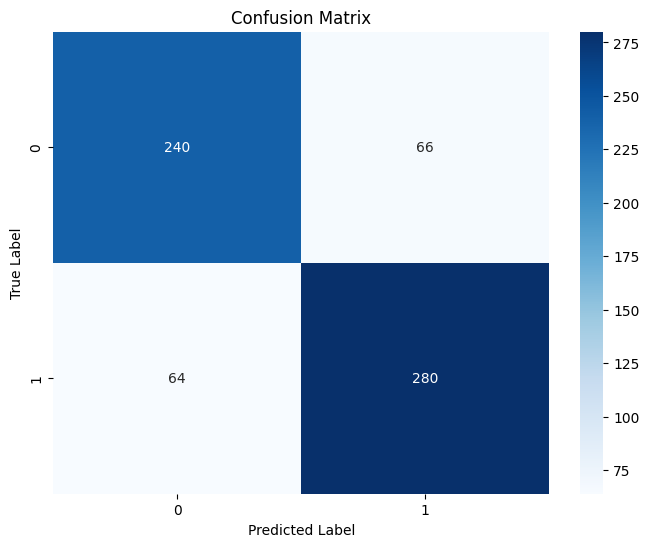

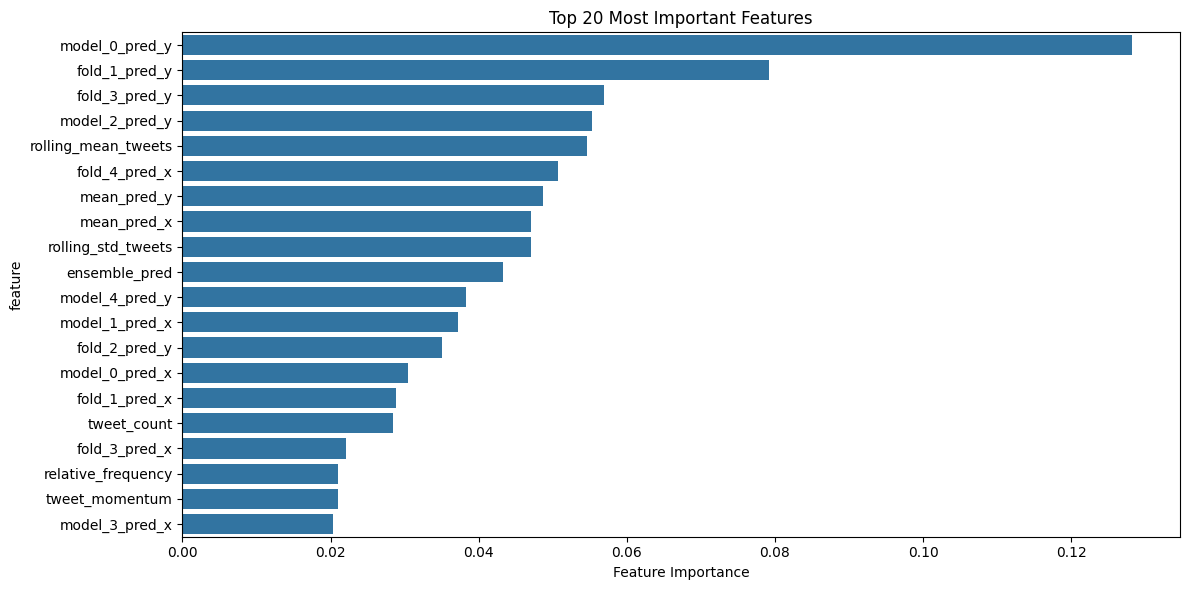

Successfully saved model at models/meta_models/tabnet_model.zip

Prediction Statistics:
Number of predictions: 516
Distribution of predictions:
EventType
1    0.552326
0    0.447674
Name: proportion, dtype: float64


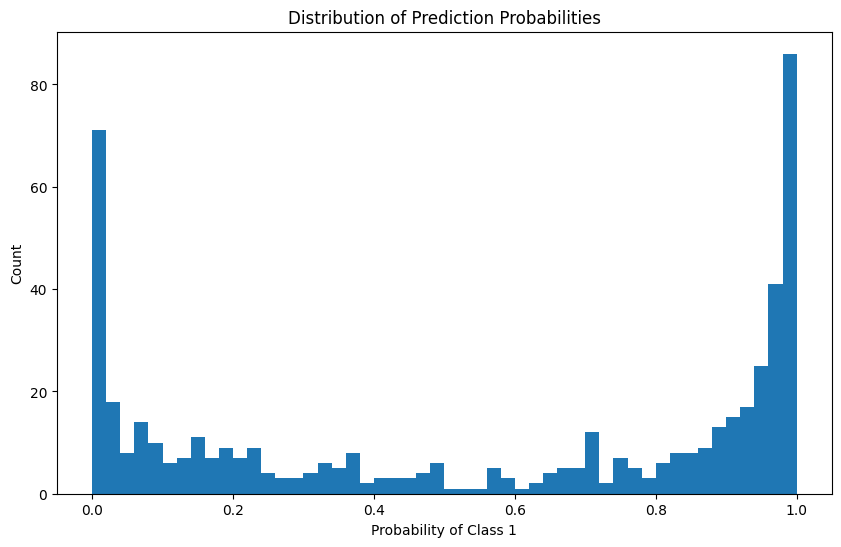

In [18]:

# 1. Prepare the training data
train_df = prepare_data(train_models, train_time_features)

# 2. Split into train and validation sets
train_data, val_data = split_data(train_df, val_size=0.3)

# 3. Train the model
model, feature_cols, scaler = train_tabnet_model(train_data, val_data)

# 4. Make predictions on validation set
X_val = scaler.transform(val_data[feature_cols].values).astype(np.float32)
y_val = val_data['EventType'].values
val_preds = model.predict(X_val)
val_proba = model.predict_proba(X_val)

# 5. Evaluate the model
print("\nClassification Report:")
print(classification_report(y_val, val_preds))

# 6. Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, val_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 7. Plot feature importance
plt.figure(figsize=(12, 6))
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

sns.barplot(data=feature_importance.head(20), x='importance', y='feature')
plt.title('Top 20 Most Important Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

# 8. Create submission for test set
submission_df, test_proba = create_submission(
    test_models, 
    test_time_features, 
    model, 
    feature_cols,
    scaler
)

# 9. Save the submission
submission_df.to_csv('submission_tabnet_80.csv', index=False)

# 10. Save the model for later use
model.save_model('models/meta_models/tabnet_model')


# 11. Print predictions statistics
print("\nPrediction Statistics:")
print(f"Number of predictions: {len(submission_df)}")
print(f"Distribution of predictions:")
print(submission_df['EventType'].value_counts(normalize=True))

# 12. Plot probability distribution
plt.figure(figsize=(10, 6))
plt.hist(test_proba[:, 1], bins=50)
plt.title('Distribution of Prediction Probabilities')
plt.xlabel('Probability of Class 1')
plt.ylabel('Count')
plt.show()